# Coursera Capstone: The Battle of the Neighborhoods
### Categorisation of Neighborhoods in the Norwich urban area

## Setup

Ensure the necessary packages for mapping and handling geospatial data are installed.

In [1]:
#!pip install geojson
#!conda install -c conda-forge folium=0.5.0 --yes 
#!conda install -c conda-forge geopy --yes 
#!conda install geopandas --yes

Import the necessary libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import geopandas as gp

import json # library to handle JSON files

import geojson as gs #libary to handle GeoJSON

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing

import folium # map rendering library

#import plotly.graph_objects as go

from sklearn.metrics import silhouette_samples, silhouette_score

print('Libraries imported.')

Libraries imported.


In the cell below we load Foursquare credentials. I have hidden these cells, the only output is a message confirming they have been stored

In [3]:

CLIENT_ID = 'XXXX' # Please copy paste your own credentials
CLIENT_SECRET = 'XXX' # Please copy paste your own credentials
VERSION = '20190605' # Foursquare API version
LIMIT = 50 #setting limit
print("Credentials successfully stored")


Credentials successfully stored


The first thing we will do is obtain the co-ordinates of the city of Norwich, UK. 


In [4]:
address = 'Norwich, UK'

geolocator = Nominatim(user_agent="norwich")
location = geolocator.geocode(address)
lat_1 = location.latitude
long_1 = location.longitude
print('{} co-ordinates: {}, {}.'.format(address, lat_1, long_1))

Norwich, UK co-ordinates: 52.628606, 1.29227.


Next, we load an instance of folium centred on the co-ordinates we obtained, to confirm we have the right location

In [5]:
map_norwich = folium.Map(location=[lat_1, long_1], zoom_start=12)

In [6]:
map_norwich

Looking good. We are now ready to load neighborhood data

## Gathering neighborhood boundaries data

The first thing we will do is load the raw data from the ONS portal. This data is in geopandas format, so we define a GeoDataframe based on the outputs of the call.

In [7]:
url_nor="https://opendata.arcgis.com/datasets/da831f80764346889837c72508f046fa_0.geojson?where=UPPER(lsoa11nm)%20like%20'%25NORWICH%25'"
nor=gp.read_file(url_nor)

In [8]:
nor.head()

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areashape,st_lengthshape,geometry
0,26103,E01026791,Norwich 005A,Norwich 005A,205149.204816,3433.502284,"POLYGON ((1.225863990204819 52.63933693544302,..."
1,26104,E01026792,Norwich 005B,Norwich 005B,356110.037057,5020.017351,"POLYGON ((1.217726556098618 52.63729551627718,..."
2,26105,E01026793,Norwich 005C,Norwich 005C,292194.535432,3675.840455,"POLYGON ((1.232626869304423 52.63835238620026,..."
3,26106,E01026794,Norwich 005D,Norwich 005D,756144.225072,4106.007268,"POLYGON ((1.204731578925866 52.64093297796994,..."
4,26107,E01026796,Norwich 005F,Norwich 005F,372798.963010,3598.567709,"POLYGON ((1.238976461466728 52.63593313005011,..."


Lets add these to our map and see what the output gives

In [9]:
map_norwich = folium.Map(location=[lat_1, long_1], zoom_start=12)

folium.GeoJson(nor["geometry"]).add_to(map_norwich)
               
map_norwich


It looks like we have been successful. The "Geometry" column contains data on the shape of each LSOA. For our analysis, we want to define the centres of each of these polygons. 

So lets go ahead and extract the centroids of these shapes. 

Fortunately, we know that one of the attributes of the "geometry" is the centroid - the point which is minimises the combined distance from all edges of the polygon. 

Let's do this.

In [10]:
#define a function that extracts an x and a y value when given the co-ordinates of a point
def getXY(pt):
    return (pt.x, pt.y)

#generate a geopandas geoseries of the centroids of each polygon
centroidseries = nor['geometry'].centroid

#define x and y as lists 
#in the below; "map" applies the function getXY over the centroid series, creating a series of x,y tuples.
#zip turns these into iterables (effectively splits the x,y pairs).
#the * in front of m tells the zip function to work element by element, not on the whole map at once

x,y = [list(t) for t in zip(*map(getXY, centroidseries))]

#Define a pandas DataFrame from the geopandas GeoDataFrame

df=pd.DataFrame(nor)

#Add the x and y co-ordinates

df["long"]=x
df["lat"]=y
df.head()

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areashape,st_lengthshape,geometry,long,lat
0,26103,E01026791,Norwich 005A,Norwich 005A,205149.204816,3433.502284,"POLYGON ((1.225863990204819 52.63933693544302,...",1.229414,52.640044
1,26104,E01026792,Norwich 005B,Norwich 005B,356110.037057,5020.017351,"POLYGON ((1.217726556098618 52.63729551627718,...",1.221602,52.640558
2,26105,E01026793,Norwich 005C,Norwich 005C,292194.535432,3675.840455,"POLYGON ((1.232626869304423 52.63835238620026,...",1.234784,52.637909
3,26106,E01026794,Norwich 005D,Norwich 005D,756144.225072,4106.007268,"POLYGON ((1.204731578925866 52.64093297796994,...",1.211771,52.641307
4,26107,E01026796,Norwich 005F,Norwich 005F,372798.963010,3598.567709,"POLYGON ((1.238976461466728 52.63593313005011,...",1.237788,52.633661


Great! We have successfully converted the LSOA polygons into a set of centroid points. 

Lets drop the "Geometry" column as it is no longer useful, and rename the "LSOA11NM" column to simply "Neighborhood"

In [11]:
df1=df.drop(columns=["geometry"])
df2=df1.rename(columns={"lsoa11nm":"Neighborhood"})
df2.head()

,objectid,lsoa11cd,Neighborhood,lsoa11nmw,st_areashape,st_lengthshape,long,lat
0,26103,E01026791,Norwich 005A,Norwich 005A,205149.204816,3433.502284,1.229414,52.640044
1,26104,E01026792,Norwich 005B,Norwich 005B,356110.037057,5020.017351,1.221602,52.640558
2,26105,E01026793,Norwich 005C,Norwich 005C,292194.535432,3675.840455,1.234784,52.637909
3,26106,E01026794,Norwich 005D,Norwich 005D,756144.225072,4106.007268,1.211771,52.641307
4,26107,E01026796,Norwich 005F,Norwich 005F,372798.963010,3598.567709,1.237788,52.633661


All done

Now lets see what the map looks like with the Neighborhood centroids added as a feature

In [12]:
map_norwich = folium.Map(location=[lat_1, long_1], zoom_start=12)

for lat, lng, label in zip(df2['lat'], df2['long'], df2['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_norwich)  

In [13]:
map_norwich

Now we can see that there is one neighborhood, "Norwich 001A", which is located right next to the airport. Lets assume that for our stakeholder group, this is not a neighborhood that would be desirable.

Also, being an airport, we can expect that the venues in this location will be highly atypical.So this is an outlier which could adversely impact our clusters. 

Lets go ahead and get rid of it.

In [14]:
df2=df2[~df2.Neighborhood.isin(["Norwich 001A"])]

In [15]:
map_norwich = folium.Map(location=[lat_1, long_1], zoom_start=12, control_scale = True)

for lat, lng, label in zip(df2['lat'], df2['long'], df2['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_norwich)  
    
map_norwich

Success. The airport neighborhood is officially gone.

## Gathering Foursquare venues data

Now lets define some parameters we will use to scan Foursquare. 

The first thing we should think about is the radius we will use. 

Since the neighborhoods are non-uniformly distributed, we want to pick a radius which as much as possible minimises overlap but also minimises the amount of "unswept area" (ie area which does not fall within the radius of a neighborhood)

Based on inspecting the map, we choose 1km (1000m)

Next we define a "getNearbyVenues" function which will obtain the list of venues found within each Neighborhood's target radius

In [16]:
radius=1000

def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, long in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            long, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Lets run this function for norwich, and define a DataFrame for the result.

In [17]:
norwich_venues = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['lat'],
                                   longitudes=df2['long']
                                  )


In [18]:
norwich_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Norwich 005A,52.640044,1.311284,Aldi,52.639122,1.241439,Supermarket
1,Norwich 005A,52.640044,1.311284,Cherry Tree Pub,52.640949,1.235930,Pub
2,Norwich 005A,52.640044,1.311284,The FDC,52.642093,1.221867,Soccer Field
3,Norwich 005A,52.640044,1.311284,Castle Carvery,52.642800,1.218832,Restaurant
4,Norwich 005A,52.640044,1.311284,Best Western Brook Hotel Norwich,52.643291,1.217827,Hotel


Success!

Now lets inspect the venues list which has been produced. 

As an overview, we will look at the number of unique venue categories found, and then see which ones appear most frequently in a Neighborhood's radius

In [19]:
print(" ")
print(len(pd.unique(norwich_venues["Venue Category"])), "unique venue categories found in Norwich")
print(" ")
print("The most commonly occuring venue categories in the vicinity of a neighbourhood are (by count of occurence): ")
print(" ")
print(pd.DataFrame(norwich_venues["Venue Category"].value_counts().head(20)))

print(" ")
print("The least commonly occuring venue categories in the vicinity of a neighbourhood are (by count of occurence: ")
print(" ")
print(pd.DataFrame(norwich_venues["Venue Category"].value_counts().tail(20)))

 
108 unique venue categories found in Norwich
 
The most commonly occuring venue categories in the vicinity of a neighbourhood are (by count of occurence): 
 
                      Venue Category
Pub                              338
Grocery Store                    104
Café                              83
Coffee Shop                       82
Supermarket                       63
Fast Food Restaurant              57
Hotel                             56
Bar                               56
Park                              55
Pizza Place                       54
Chinese Restaurant                51
Restaurant                        33
Theater                           31
Shopping Mall                     30
American Restaurant               28
Indian Restaurant                 27
Tea Room                          27
Convenience Store                 27
Italian Restaurant                26
Sandwich Place                    25
 
The least commonly occuring venue categories in the vicinity 

## Preparing data for clustering algorithm

We start by creating dummies from the Venue category of the norwich_venues DataFrame. The "get_dummies" function does this by performing Onehot encoding on the selected column. 

In [20]:
# one hot encoding
norwich_onehot = pd.get_dummies(norwich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
norwich_onehot['Neighborhood'] = norwich_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [norwich_onehot.columns[-1]] + list(norwich_onehot.columns[:-1])
norwich_onehot = norwich_onehot[fixed_columns]

norwich_onehot.head()


,Neighborhood,American Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,Automotive Shop,Bakery,Bar,...,Storage Facility,Supermarket,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Warehouse Store
0,Norwich 005A,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Norwich 005A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Norwich 005A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Norwich 005A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Norwich 005A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
norwich_onehot.shape

(1910, 109)

Now, we want to group by the Neighborhood column, so that we have one row per Neighborhood, and the values represent the average occurence rate of a given venue type in that neighborhood. 

We expect that the values will be no lower than zero and no higher than 1. We also note that for the value to be one, all of the venues in that neighborhood would have to be of the same category; a very unlikely occurence. 

In [22]:
norwich_grouped = norwich_onehot.groupby('Neighborhood').mean().reset_index()
norwich_grouped.head()

,Neighborhood,American Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,Automotive Shop,Bakery,Bar,...,Storage Facility,Supermarket,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Warehouse Store
0,Norwich 001B,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.100000,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0
1,Norwich 001C,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Norwich 001D,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,...,0.0,0.187500,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.0
3,Norwich 001E,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,...,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0
4,Norwich 001F,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0


In [23]:
norwich_grouped_clustering = norwich_grouped.drop('Neighborhood', 1)
norwich_grouped_clustering.head()

,American Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,Automotive Shop,Bakery,Bar,Bed & Breakfast,...,Storage Facility,Supermarket,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Warehouse Store
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.100000,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,...,0.0,0.187500,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,...,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0
4,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0


## Validating the selection of k clusters

### Elbow analysis

First, we will assess how the k-means score changes with respect to different values of k. This should give us a good level of assurance of our selection of k,the number of clusters

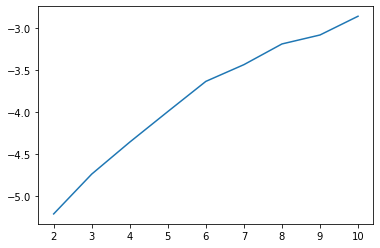

In [24]:
#Define procedure to iteratively compute k-means score for k values from 1 to 10

Ks = range(2, 11)
km = [KMeans(n_clusters=i, random_state=0) for i in Ks]
score = [km[i].fit(norwich_grouped_clustering).score(norwich_grouped_clustering) for i in range(len(km))]
plt.plot(Ks, score)

We can see that the k-means score does not produce an obvious elbow beyond k=2. However the curve begins to flatten gently after k=5. This suggests our choice of k is a resonable one

### Silhouette plot

Silhouette is a technique which provides a succinct graphical representation of how well each object in a cluster has been classified

The silhouette value (or score) per object effectively measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. 

If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

Let's go ahead and test the silhouette scores for different values of k

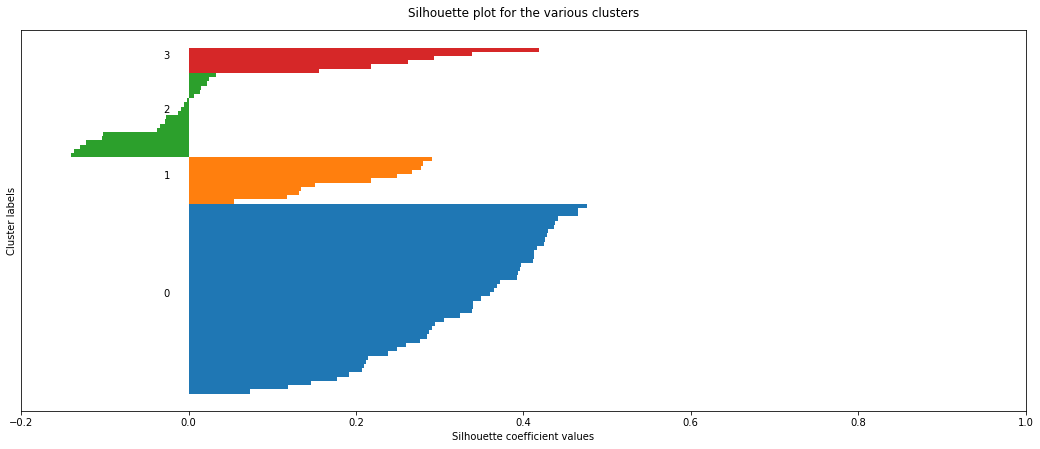

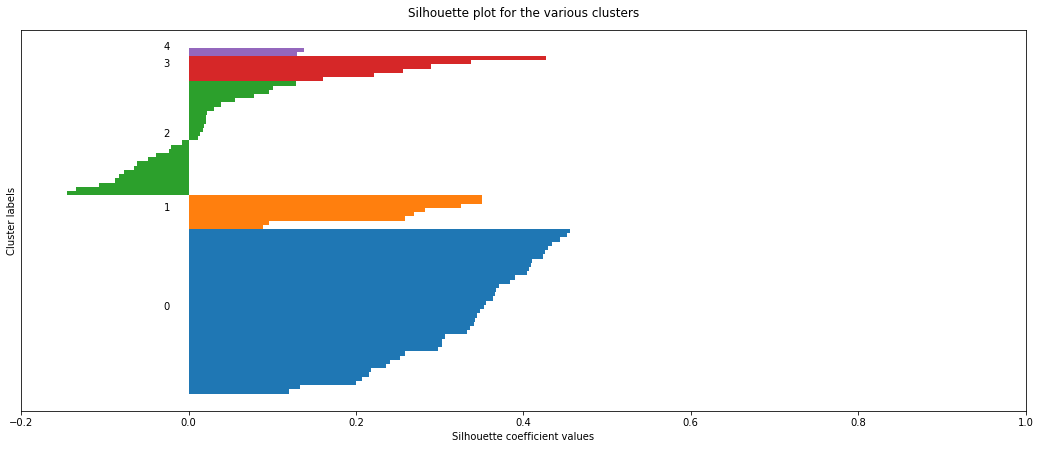

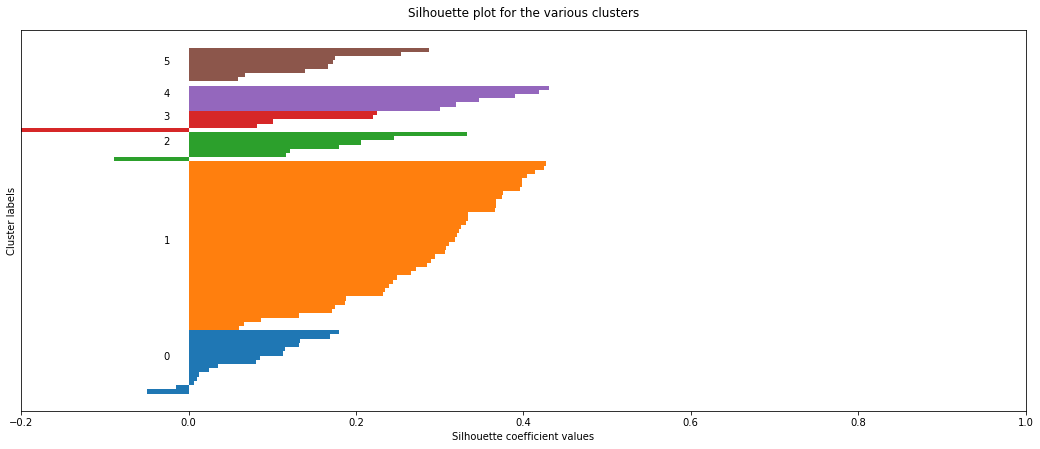

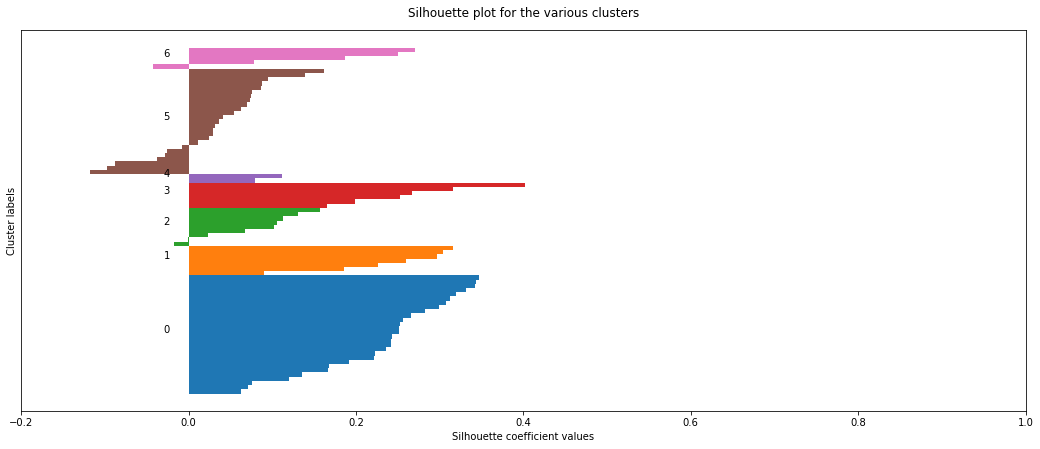

In [25]:
for i, k in enumerate([4,5,6,7]):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(norwich_grouped_clustering)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(norwich_grouped_clustering, labels)

    # Make the silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    #avg_score = np.mean(silhouette_vals)
    #ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    
    # Set plotting parameters
    ax1.set_yticks([])
    ax1.set_xlim([-0.2, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);   


k=6 appears to give the most satisfactory results. 

<b> We therefore proceed with k=6 for analysis and final results</b>

In [26]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(norwich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print("There are {} clusters".format(kclusters),"labelled", np.unique(kmeans.labels_))
print("The k means score is", kmeans.score(norwich_grouped_clustering))


There are 6 clusters labelled [0 1 2 3 4 5]
The k means score is -3.6319202934451473


## Analysis of results

First lets take a look at our DataFrame norwich_grouped

In [27]:
norwich_grouped.head()

,Neighborhood,American Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,Automotive Shop,Bakery,Bar,...,Storage Facility,Supermarket,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Warehouse Store
0,Norwich 001B,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.100000,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0
1,Norwich 001C,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Norwich 001D,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,...,0.0,0.187500,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.0
3,Norwich 001E,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,...,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0
4,Norwich 001F,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0


First we will define a function which, for a given row in norwich_grouped, sorts the venues from most common to least common. Let's break this down.

Take the first row of the DataFrame

In [28]:
norwich_grouped.iloc[0]

Neighborhood                     Norwich 001B
American Restaurant                         0
Antique Shop                                0
Art Museum                                  0
Arts & Crafts Store                         0
                                     ...     
Theater                                   0.1
Toy / Game Store                            0
Train Station                               0
Vegetarian / Vegan Restaurant               0
Warehouse Store                             0
Name: 0, Length: 109, dtype: object

This is a series. Lets specify that we want to sort the values in descending order, starting from the second member of the series (ie skipping "Neighborhood", "Norwich 00B"

In [29]:
norwich_grouped.iloc[0].iloc[1:].sort_values(ascending=False)

Grocery Store           0.2
Park                    0.2
Market                  0.1
Theater                 0.1
Supermarket             0.1
                       ... 
Music Venue               0
Nightclub                 0
Optical Shop              0
Outdoor Supply Store      0
American Restaurant       0
Name: 0, Length: 108, dtype: object

Great. Now all we need to do is extract the first n venue categories to make our top n list. Let n be 10, to show a top 10 view.

In [30]:
norwich_grouped.iloc[0].iloc[1:].sort_values(ascending=False).index.values[0:10]

array(['Grocery Store', 'Park', 'Market', 'Theater', 'Supermarket',
       'Discount Store', 'Café', 'Roller Rink', 'Fast Food Restaurant',
       'Construction & Landscaping'], dtype=object)

Great. Now all we have to do is repeat this procedure for every row in norwich grouped. 

Let's start by generalising what we just did into a function.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

And now lets define a new DataFrame which will display the Top 10 for each neighborhood

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = norwich_grouped['Neighborhood']

for ind in np.arange(norwich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(norwich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Norwich 001B,Grocery Store,Park,Market,Theater,Supermarket,Discount Store,Café,Roller Rink,Fast Food Restaurant,Construction & Landscaping
1,Norwich 001C,Park,Grocery Store,Convenience Store,Fish & Chips Shop,Discount Store,Roller Rink,Café,Furniture / Home Store,Deli / Bodega,Department Store
2,Norwich 001D,Park,Supermarket,Pub,Grocery Store,Theater,Bar,Discount Store,Restaurant,Café,Market
3,Norwich 001E,Pub,Park,Fish & Chips Shop,Fast Food Restaurant,Theater,Pharmacy,Grocery Store,Supermarket,Rock Club,Café
4,Norwich 001F,Furniture / Home Store,Hardware Store,Rock Club,Fast Food Restaurant,Gas Station,Indian Restaurant,Pet Store,Pub,American Restaurant,Supermarket


Next we add the cluster labels

In [33]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Norwich 001B,Grocery Store,Park,Market,Theater,Supermarket,Discount Store,Café,Roller Rink,Fast Food Restaurant,Construction & Landscaping
1,0,Norwich 001C,Park,Grocery Store,Convenience Store,Fish & Chips Shop,Discount Store,Roller Rink,Café,Furniture / Home Store,Deli / Bodega,Department Store
2,0,Norwich 001D,Park,Supermarket,Pub,Grocery Store,Theater,Bar,Discount Store,Restaurant,Café,Market
3,0,Norwich 001E,Pub,Park,Fish & Chips Shop,Fast Food Restaurant,Theater,Pharmacy,Grocery Store,Supermarket,Rock Club,Café
4,2,Norwich 001F,Furniture / Home Store,Hardware Store,Rock Club,Fast Food Restaurant,Gas Station,Indian Restaurant,Pet Store,Pub,American Restaurant,Supermarket


We would now like to see how the clusters look on a map. 

The first step is to merge the neighborhood venues data with the geospatial co-ordinates data we stored in df2.

We do just that

In [34]:
#define new DataFrame - Norwich_merged, containing lat/long data

norwich_merged = df2

#merge this dataframe with the neighborhoods data
norwich_merged = norwich_merged.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
norwich_merged.head() 

,objectid,lsoa11cd,Neighborhood,lsoa11nmw,st_areashape,st_lengthshape,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,26103,E01026791,Norwich 005A,Norwich 005A,205149.204816,3433.502284,1.229414,52.640044,3,Grocery Store,Hotel,Fast Food Restaurant,Soccer Field,Department Store,Convenience Store,Pub,Restaurant,Bowling Alley,Shopping Mall
1,26104,E01026792,Norwich 005B,Norwich 005B,356110.037057,5020.017351,1.221602,52.640558,3,Hotel,Storage Facility,Bowling Alley,Soccer Field,Restaurant,Pub,Shoe Store,Shopping Mall,Department Store,Grocery Store
2,26105,E01026793,Norwich 005C,Norwich 005C,292194.535432,3675.840455,1.234784,52.637909,4,Fast Food Restaurant,Convenience Store,Pub,Soccer Field,Bakery,Supermarket,Chinese Restaurant,Grocery Store,Department Store,Fish & Chips Shop
3,26106,E01026794,Norwich 005D,Norwich 005D,756144.225072,4106.007268,1.211771,52.641307,3,Hotel,Bowling Alley,Grocery Store,Department Store,Soccer Field,Shopping Mall,Restaurant,Event Service,Falafel Restaurant,Fish & Chips Shop
4,26107,E01026796,Norwich 005F,Norwich 005F,372798.963010,3598.567709,1.237788,52.633661,4,Fast Food Restaurant,Grocery Store,Park,Chinese Restaurant,Pub,Supermarket,Warehouse Store,Convenience Store,Deli / Bodega,Department Store


We can now add the cluster info to the map as a colour scheme

In [35]:
# create map
norwich_clusters = folium.Map(location=[lat_1, long_1], zoom_start=11, control_scale = True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(norwich_merged['lat'], norwich_merged['long'], norwich_merged['Neighborhood'], norwich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=1).add_to(norwich_clusters)
    
folium.TileLayer('openstreetmap').add_to(norwich_clusters)

norwich_clusters


Finally, we can define a summary table to give a flavour of what types of venues occur most commonly in our clusters.

In [36]:
cluster_x=pd.DataFrame()

for i in range(kclusters):
    cluster_i =norwich_merged.loc[norwich_merged['Cluster Labels'] == i,  norwich_merged.columns[[3] + list(range(5, norwich_merged.shape[1]))]]
    cluster_x = cluster_x.append({'Cluster': i,
                                      'Number of neighborhoods': cluster_i.shape[0],
                                      '1st most common venue': cluster_i["1st Most Common Venue"].mode().tolist(),
                                      '2nd most common venue': cluster_i["2nd Most Common Venue"].mode().tolist(),
                                      '3rd most common venue': cluster_i["3rd Most Common Venue"].mode().tolist(),
                                      '4th most common venue': cluster_i["4th Most Common Venue"].mode().tolist(),
                                      '5th most common venue': cluster_i["5th Most Common Venue"].mode().tolist()}, 
                                     ignore_index=1)

# move neighborhood column to the first column
col_fixed= list(cluster_x.columns[-2:]) + list(cluster_x.columns[:5])
cluster_x = cluster_x[col_fixed].set_index("Cluster")

cluster_x

,Number of neighborhoods,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
Cluster,,,,,,
0.0,15.0,[Grocery Store],[Park],"[Convenience Store, Pub]",[Grocery Store],"[Breakfast Spot, Event Service, Park, Theater]"
1.0,40.0,[Pub],[Coffee Shop],[Café],"[Café, Grocery Store]","[Café, Pizza Place]"
2.0,7.0,[Furniture / Home Store],[Fast Food Restaurant],"[American Restaurant, Supermarket]","[Automotive Shop, Bar, Café, Convenience Store...",[Pub]
3.0,5.0,[Hotel],"[Bowling Alley, Department Store, Hotel, Resta...",[Shopping Mall],[Soccer Field],"[Concert Hall, Department Store, Restaurant, S..."
4.0,6.0,[Grocery Store],"[Convenience Store, Fast Food Restaurant]",[Fast Food Restaurant],[Chinese Restaurant],[Pub]
5.0,9.0,[Supermarket],"[Fast Food Restaurant, Supermarket]",[Electronics Store],[Hotel],[Electronics Store]


We can now get a rough idea of what defines our clusters.